# Mejores Modelos de NN con datos especies
En este jupyter hemos incluido el guardado de las predicciones y tambien los errores por otu para poder luego verlos en un Rscript bien (hacer figuras sobre todo)

En el primer modelo estan todas las funciones necesarias y en los restantes solo la parte que no es comun ya que se deben guardadr con otros nombres

## Parte Comun

In [1]:
#Grid de la segunda parte, en la que utilizamos ya la primera parte bien
#Esta va a ser la de las 44 variables con combined


#importamos paquetes
import sys
sys.path.append('Src/')
from data_modificado import * #hay funciones que estan cambiadas en este script para adaptralas a nuestro dataset
from train_2 import * #este hubo que modificar una linea tambien
from transfer_learning import * #hubo que modificart lo mismo que en train_2
from transfer_learning_FI import * #necesario para el Feature Importance
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import itertools as it

#funciones
def read_df(
              metadata_names=['age','Temperature','Precipitation3Days'],
              random_state=42,
              otu_filename='../Datasets/otu_table_all_80.csv',
              metadata_filename='../Datasets/metadata_table_all_80.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None).T
    #print(otu.head())
    otu = otu.set_index('otuids')
    otu = otu.astype('int32')
    metadata = pd.read_csv(metadata_filename)
    #print(metadata.head())
    metadata = metadata.set_index('X.SampleID')
    metadata.head()
    domain = metadata[metadata_names]
    #if 'INBREDS' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['INBREDS'], prefix='INBREDS')], axis=1)
    #    domain = domain.drop(['INBREDS'], axis=1)
    #elif 'Maize_Line' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['Maize_Line'], prefix='Maize_Line')], axis=1)
    #    domain = domain.drop(['Maize_Line'], axis=1) 
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    #print(df.head())
    #data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    #data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    df_microbioma = df[otu.columns]
    df_domain = df[domain.columns]
    df_domain.head()
    df_microbioma_train, df_microbioma_no_train, df_domain_train, df_domain_no_train = \
        train_test_split(df_microbioma, df_domain, test_size=0.1, random_state=random_state)
    # Transfer learning subset
    df_microbioma_test, df_microbioma_transfer_learning, df_domain_test, df_domain_transfer_learning = \
        train_test_split(df_microbioma_no_train, df_domain_no_train, test_size=0.1, random_state=random_state)
    df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test = \
        train_test_split(df_microbioma_transfer_learning, df_domain_transfer_learning, test_size=0.3, random_state=random_state)
    
    return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns
    #return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns


def train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                batch_size, epochs, train_callbacks):
    all_models = model_fn()
    model, encoder_bioma, encoder_domain, decoder_bioma = all_models
    metrics_prefix = None
    if encoder_bioma is not None and encoder_domain is not None:
        x_train = (m_train, d_train)
        y_train = (m_train, m_train, z_train)
        x_test = (m_test, d_test)
        y_test = (m_test, m_test, z_test)
    elif encoder_bioma is not None:
        x_train = m_train
        y_train = m_train
        x_test = m_test
        y_test = m_test
        metrics_prefix = 'bioma'
    elif encoder_domain is not None:
        x_train = d_train
        y_train = m_train
        x_test = d_test
        y_test = m_test
        metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
        batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    del val_dataset
    del train_dataset
    del x_train
    del y_train
    del x_test
    del y_test
    return r, all_models

def train_2(model_fn,
          data_microbioma,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          learning_rate_scheduler=ExpDecayScheluder(),
          random_seed=347,
          verbose=0):
    data_zeros_latent = np.zeros((data_microbioma.shape[0], latent_space), dtype=data_microbioma.dtype)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]
    if learning_rate_scheduler is not None:
        train_callbacks += [learning_rate_scheduler.make()]

    if folds <= 1:
        m_train, m_test = data_microbioma, data_microbioma
        d_train, d_test = data_domain, data_domain
        z_train, z_test = data_zeros_latent, data_zeros_latent
        tf.random.set_seed(random_seed)
        r, m = train_kfold(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                           batch_size, epochs, train_callbacks)
        results.append(r)
        models.append(m)

    else: #EL PROBLEMA ESTA AQUI, QUE HACE FALTA UN 
        kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
        tf.random.set_seed(random_seed)

        for train_index, test_index in kf.split(data_microbioma):
            m_train, m_test = data_microbioma[train_index], data_microbioma[test_index]
            #print(m_train)
            #d_train, d_test = data_domain[train_index], data_domain[test_index]
            if data_domain is None:
                d_train, d_test = None, None
            else:
                d_train, d_test = data_domain[train_index], data_domain[test_index]
            #print(d_train)
            #Esto de hacer el if else ha funcionado, pero no se si hace lo que debe bien
            z_train, z_test = data_zeros_latent[train_index], data_zeros_latent[test_index]
            r, m = train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                               batch_size, epochs, train_callbacks)
            results.append(r)
            models.append(m)
    return results, models

def perform_experiment_2_mod(cv_folds, epochs, batch_size, learning_rate, optimizer,
                       learning_rate_scheduler, input_transform, output_transform,
                       reconstruction_loss, latent_space, layers,
                       activation, activation_latent,
                       data_microbioma_train, data_domain_train,
                       show_results=True, device='/CPU:0'): #Show results cambiado de False  aTrue
    if input_transform is not None:
        input_transform = input_transform()
    #----------    
    if output_transform is not None:
        output_transform = output_transform()
    #----------      
    if reconstruction_loss.__class__.__name__ == 'MakeLoss':
        reconstruction_loss = reconstruction_loss.make()
    else:
        reconstruction_loss = reconstruction_loss()
    domain_layers = [l // 16 for l in layers] ####que es esto???? Esto es para las capas del domain
    #print(domain_layers)
    bioma_autoencoder = " -> ".join(["b"] +
                                    [str(l) for l in layers] +
                                    [str(latent_space)] +
                                    [str(l) for l in reversed(layers)] +
                                    ["b"])
    #---------- 
    #esto solo se utiliza para el texto, es irrelevante para nuestro error
    if data_domain_train is not None:
        domain_autoencoder = " -> ".join(["d"] +
                                     [str(l) for l in domain_layers] +
                                     [str(latent_space)] +
                                     [str(l) for l in reversed(layers)] +
                                     ["b"])
        
    else: 
        domain_autoencoder = " "
    #---------- 
    #donde se usa domain autoencoder?
    in_transform_name = input_transform.__class__.__name__ if input_transform else "none"
    out_transform_name = output_transform.__class__.__name__ if output_transform else "none"
    lr_scheduler_text = learning_rate_scheduler[
        1] if learning_rate_scheduler is not None else "none"
    lr_text = learning_rate if learning_rate_scheduler is not None else "constant = {}".format(
        learning_rate)
    learning_rate_scheduler = learning_rate_scheduler[
        0] if learning_rate_scheduler is not None else None
    optimizer = optimizer(learning_rate=learning_rate)
    #---------- 
    experiment_parameters = [
        ("Input transform", in_transform_name),
        ("Output transform", out_transform_name),
        ("Reconstruction Loss", reconstruction_loss.__class__.__name__),
        ("Latent Space", latent_space),
        ("Bioma Autoencoder", bioma_autoencoder),
        ("Domain Autoencoder", domain_autoencoder),
        ("Activation Encoder", activation),
        ("Activation Decoder", activation),
        ("Activation Latent", activation_latent),
        ("CV folds", cv_folds),
        ("Epochs", epochs),
        ("Batch Size", batch_size),
        ("Learning Rate Scheduler", lr_scheduler_text),
        ("Learning Rate", lr_text),
        ("Optimizer", optimizer.__class__.__name__),
    ]
    #----------  
    if show_results:
        md_text = ""
        md_text += "| Parameter             | Value         |\n"
        md_text += "|:----------------------|:--------------|\n"
        for n, v in experiment_parameters:
            md_text += "| {} | {} |\n".format(n, v)

        display(Markdown(md_text))
    #------------
    def create_model(print_data=False):
        bioma_shape=data_microbioma_train.shape[1]
        
        if data_domain_train is not None:
            domain_shape=data_domain_train.shape[1]
            #print("data_domain_train!=None")
        else:
            domain_shape=None
            #print("data_domain_train==None")
        models = autoencoder(bioma_shape=bioma_shape,
                             #bioma_shape=717,
                             domain_shape=domain_shape,
                             output_shape=bioma_shape,
                             #output_shape=717,
                             latent_space=latent_space,
                             bioma_layers=layers, #Esto es lo de [512,316]
                             domain_layers=domain_layers, #Esto son cada una de las layers divididas por 16
                             input_transform=input_transform,
                             output_transform=output_transform,
                             activation_function_encoder=activation,
                             activation_function_decoder=activation,
                             activation_function_latent=activation_latent)
        #Entiendo analizando lo demas que aqui NO esta el error
        #la funcion autoencoder esta en model.py (es la unica funcion en ese script)
        
        model, encoder_bioma, encoder_domain, decoder_bioma = models

        if print_data:
            plot_models(model, encoder_bioma, encoder_domain, decoder_bioma)
        compile_train(model,
                      encoder_bioma=encoder_bioma,
                      encoder_domain=encoder_domain,
                      reconstruction_error=reconstruction_loss,
                      encoded_comparison_error=losses.MeanAbsoluteError(),
                      metrics=get_experiment_metrics(input_transform, output_transform),
                      optimizer=optimizer)
        
        #print("He acabado create_model :)")
        return model, encoder_bioma, encoder_domain, decoder_bioma
    #-----------
    create_model(print_data=False)
    #-----------
    #Esta en esta seccion el problema, en train_2
    #print(data_domain_train)
    #print(latent_space)
    with tf.device(device):
        results, models = train_2(create_model,
                                data_microbioma_train,
                                data_domain_train,
                                latent_space=latent_space,
                                folds=cv_folds,
                                epochs=epochs,
                                batch_size=batch_size,
                                learning_rate_scheduler=learning_rate_scheduler,
                                verbose=-1)
    #----------
    validation_results = print_results(results, show_results=show_results)
    if show_results:
        display(Markdown("*************"))

    return experiment_parameters + validation_results, models, results

Funcion para sacar la feature Importance en cada uno de los modelos

In [2]:
def FI(): ##Hay que tener cuidado cuando se ejecute esto
    metric_results, _ = test_model_tl_noEnsemble_FI(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)
    error_original = metric_results["BrayCurtis"][0]
    metricas = dict()
    for i, variable in enumerate(nombres_metadatos):
        #print(variable)
        df1 = df_domain_test
        valores_BrayCurtis = []
        for j in range(0,10,1): #para sacar la desviacion tipica de cada uno
            #print(j)
            #shuffleamos la variable
            df1[variable] = np.random.permutation(df_domain_test[variable].values)
            data_domain_test_nueva = df1.to_numpy()
            #hacemos el modelo
            metric_results, _ = test_model_tl_noEnsemble_FI(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test_nueva)
            #valores_BrayCurtis.append(metric_results["BrayCurtis"][0]/error_original)
            valores_BrayCurtis.append(metric_results["BrayCurtis"][0]-error_original)#cualquiera de la dos, tanto division como resta vale, pero esta me parece mas facil de comparar
        metricas[variable] = valores_BrayCurtis
    return metricas

-----------------------
## Latent Space OTU

In [3]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_especies/otu_table_especies_80.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [7]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_especies/otu_table_especies_80.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')


In [8]:
df_microbioma_train

,2,6,7,16,18,20,23,24,32,35,...,719,720,721,722,728,729,731,735,736,747
MCT.f.0274,488,64,2076,179,141,261,0,0,8,127,...,0,0,1,0,3,0,2,3,0,4
MCT.f.0277,2687,972,8788,3609,350,791,6,2,16,206,...,0,0,0,0,0,0,0,0,1,2
MCT.f.0459,30887,10561,69,4383,2483,1325,1,350,19759,51,...,0,0,0,0,0,0,2,1,6,2
MCT.f.0173,20937,7140,15,10973,3701,1216,6042,1211,32,2402,...,1,2,3,1,0,0,3,0,1,0
MCT.f.0108,14159,4739,19,12660,4847,11084,11424,29478,1329,251,...,0,4,8,0,5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MCT.f.0106,12448,4762,38,13038,6846,6639,10460,16105,14302,760,...,0,1,6,1,0,2,0,0,0,1
MCT.f.0142,20230,2149,2032,4049,528,608,11431,1365,69,140,...,1,1,0,1,0,1,0,0,0,0
MCT.f.0335,29301,11712,10804,2984,964,1157,3667,5153,3883,522,...,1,1,0,0,0,5,2,0,1,1
MCT.f.0537,659,911,32,9,232,85,4,5,138,59,...,0,0,0,0,0,0,0,0,0,0


| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>95</b></p>

<b>loss</b>: 0.1720 (min: 0.1720, max: 0.1720)

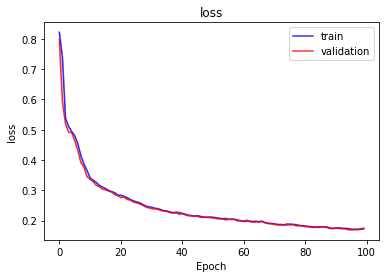

<b>bioma_mse</b>: 5217014.5000 (min: 5217014.5000, max: 5217014.5000)

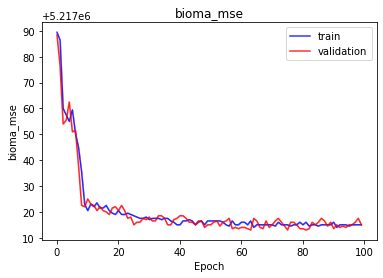

<b>bioma_mae</b>: 219.5105 (min: 219.5105, max: 219.5105)

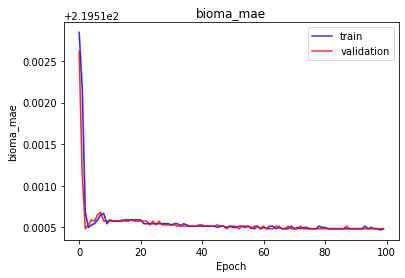

<b>bioma_mape</b>: 39895.5625 (min: 39895.5625, max: 39895.5625)

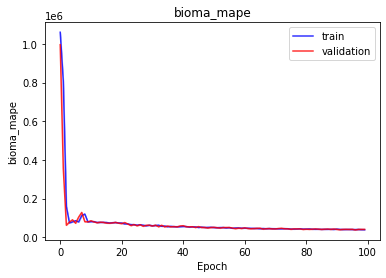

<b>bioma_BrayCurtis</b>: 0.1720 (min: 0.1720, max: 0.1720)

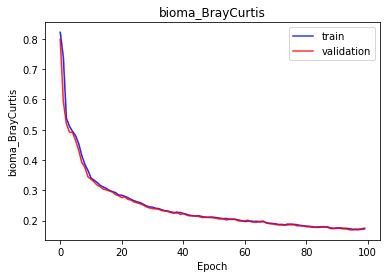

<b>bioma_pearson_corr</b>: 0.9550 (min: 0.9550, max: 0.9550)

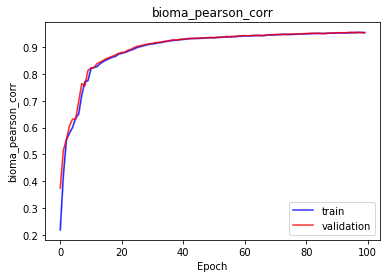

<b>bioma_jensen_shannon_divergence</b>: 0.3410 (min: 0.3410, max: 0.3410)

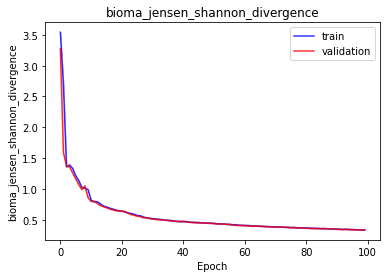

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.1720302402973175 | 0.1720302402973175 | 0.1720302402973175 |
| bioma_mse | 5217014.5 | 5217014.5 | 5217014.5 |
| bioma_mae | 219.510498046875 | 219.510498046875 | 219.510498046875 |
| bioma_mape | 39895.5625 | 39895.5625 | 39895.5625 |
| bioma_BrayCurtis | 0.1720302402973175 | 0.1720302402973175 | 0.1720302402973175 |
| bioma_pearson_corr | 0.9550129771232605 | 0.9550129771232605 | 0.9550129771232605 |
| bioma_jensen_shannon_divergence | 0.34102556109428406 | 0.34102556109428406 | 0.34102556109428406 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.45436546206474304 | 0.45436546206474304 | 0.45436546206474304 |
| pearson_corr | 0.6401063799858093 | 0.6401063799858093 | 0.6401063799858093 |
| jensen_shannon_divergence | 1.2251265048980713 | 1.2251265048980713 | 1.2251265048980713 |


In [4]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

------------
Vamos a guardar la informacion para hacer los scipts para ver lso errores por otu y las predicciones para poder ver su significancia

In [5]:
encoder_biome = encoder
encoder_domain = model_latent

In [6]:
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_OTU_comida.tsv', index=True, header=True, sep='\t')

In [7]:
##Creo que esto es comun, por lo que no hay que pasarlo a todas
def save_predicted_otu_table_and_latent(pred,pred_latent,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('Results/otus_'+suffix+'.tsv', index=True, header=True, sep='\t')

    df_latent = pd.DataFrame(pred_latent, index=sample_names)
    df_latent.T.to_csv('Results/latent_'+suffix+'.tsv', index=True, sep='\t')
    
    return df_otu, df_latent

In [8]:
#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTU_comida')

In [9]:
#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTU_comida')

In [10]:
#Compute metrics by OTU
# Absolute abundance transformed to TSS (with epsilon=1E-6)
def transform_to_rel_abundance(dataset):
    epsilon=1E-6
    sum_per_sample = dataset.sum(axis=1)
    num_samples = sum_per_sample.shape
    num_OTUs = np.shape(dataset)[-1] 
    sum_per_sample = sum_per_sample + (num_OTUs * epsilon)
    dividend=dataset+epsilon
    dataset_rel_abund = np.divide(dividend,sum_per_sample[:,None])
    #display(Markdown("{}</p>".format(np.array2string(actual_array,precision=6,floatmode='fixed'))))
    #actual_array.sum(axis=1)
    return dataset_rel_abund
def compute_relative_squared_error(actual,pred):
    rse_otu=np.zeros(actual.shape[1],dtype=np.float32)
    actual=actual_array.transpose()
    pred=pred_domain.transpose()
    # for each OTU
    for i, (act_otu,pred_otu) in enumerate(zip(actual,pred)):
        mean_otu = act_otu.mean()
        #display(Markdown("{} (mean(act)): {}</p>".format(i,mean_otu)))
        #display(Markdown("{} (act): {}</p>".format(i,np.array2string(act_otu,precision=8,floatmode='fixed'))))
        #display(Markdown("{} (pred): {}</p>".format(i,np.array2string(pred_otu,precision=8,floatmode='fixed'))))
        div_up=((pred_otu-act_otu)**2).sum()
        div_down=((pred_otu-mean_otu)**2).sum()
        rse_otu[i]=div_up/div_down
    return rse_otu, np.sqrt(rse_otu)

In [11]:
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

In [12]:
def save_errors_per_OTU(RSE,RRSE,otu_names,suffix=''):
    df_RSE = pd.DataFrame(RSE, index=otu_names, columns=['RSE'])
    df_RRSE = pd.DataFrame(RRSE, index=otu_names, columns=['RRSE'])
    df_error = df_RSE.join(df_RRSE)
    df_error.to_csv(suffix+'.tsv', index=True, header=True, sep='\t')
    
    return df_error

In [13]:
df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_OTU_comida')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_OTU_especie.csv",index=False)

------------------
## Latent Space Combined

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>92</b></p>

<b>loss</b>: 0.7106 (min: 0.7106, max: 0.7106)

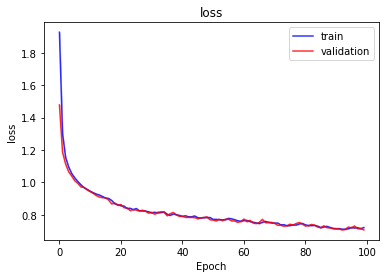

<b>bioma_loss</b>: 0.2478 (min: 0.2478, max: 0.2478)

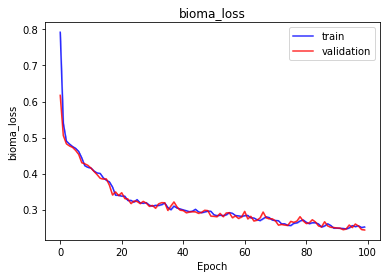

<b>domain_loss</b>: 0.4290 (min: 0.4290, max: 0.4290)

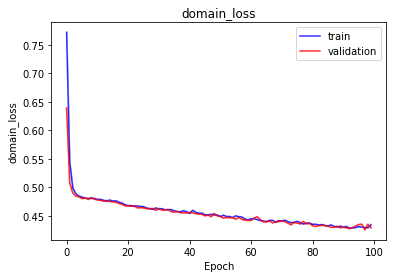

<b>latent_loss</b>: 0.0339 (min: 0.0339, max: 0.0339)

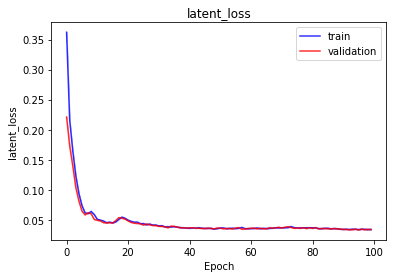

<b>bioma_mse</b>: 5217017.0000 (min: 5217017.0000, max: 5217017.0000)

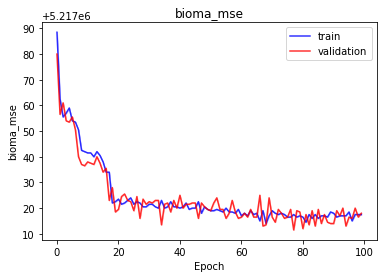

<b>bioma_mae</b>: 219.5105 (min: 219.5105, max: 219.5105)

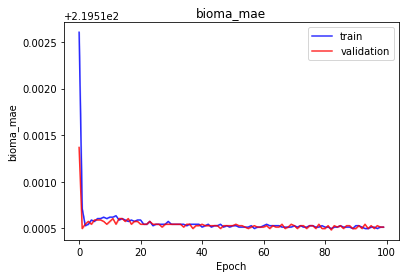

<b>bioma_mape</b>: 53154.2578 (min: 53154.2578, max: 53154.2578)

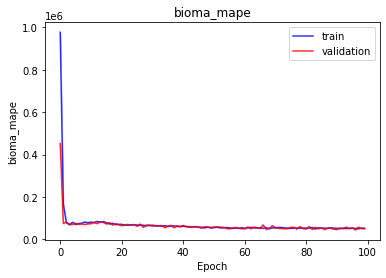

<b>bioma_BrayCurtis</b>: 0.2478 (min: 0.2478, max: 0.2478)

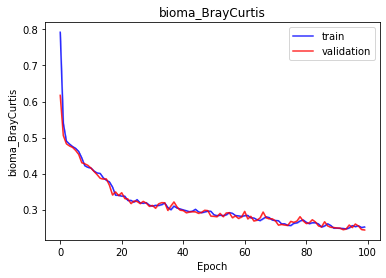

<b>bioma_pearson_corr</b>: 0.9106 (min: 0.9106, max: 0.9106)

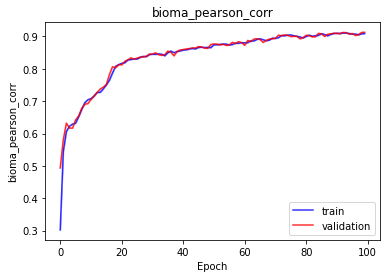

<b>bioma_jensen_shannon_divergence</b>: 0.5349 (min: 0.5349, max: 0.5349)

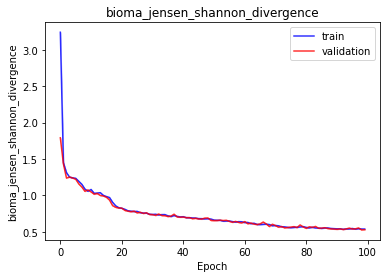

<b>domain_mse</b>: 5217044.0000 (min: 5217044.0000, max: 5217044.0000)

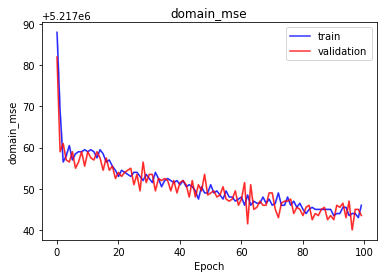

<b>domain_mae</b>: 219.5106 (min: 219.5106, max: 219.5106)

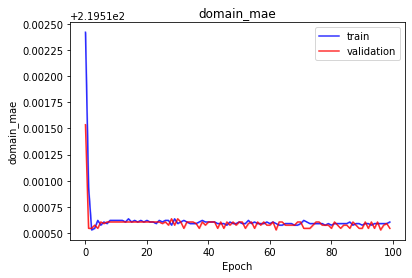

<b>domain_mape</b>: 76887.6172 (min: 76887.6172, max: 76887.6172)

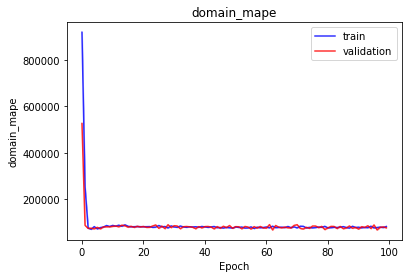

<b>domain_BrayCurtis</b>: 0.4290 (min: 0.4290, max: 0.4290)

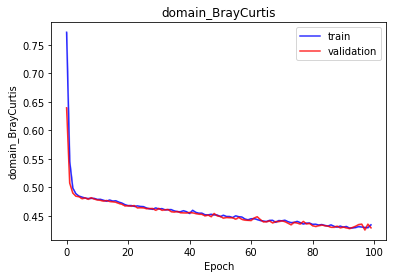

<b>domain_pearson_corr</b>: 0.6862 (min: 0.6862, max: 0.6862)

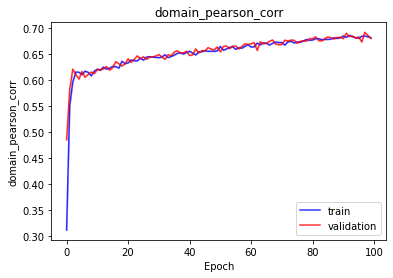

<b>domain_jensen_shannon_divergence</b>: 1.0878 (min: 1.0878, max: 1.0878)

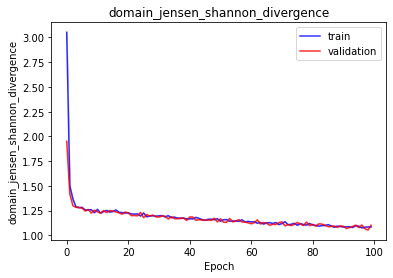

<b>latent_mae</b>: 0.0339 (min: 0.0339, max: 0.0339)

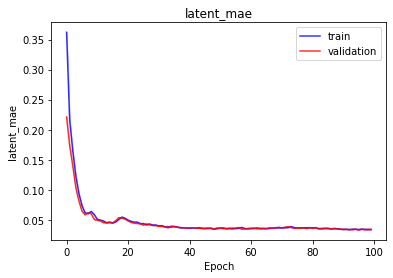

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.7105904221534729 | 0.7105904221534729 | 0.7105904221534729 |
| bioma_loss | 0.24776065349578857 | 0.24776065349578857 | 0.24776065349578857 |
| domain_loss | 0.42895424365997314 | 0.42895424365997314 | 0.42895424365997314 |
| latent_loss | 0.03387559950351715 | 0.03387559950351715 | 0.03387559950351715 |
| bioma_mse | 5217017.0 | 5217017.0 | 5217017.0 |
| bioma_mae | 219.51051330566406 | 219.51051330566406 | 219.51051330566406 |
| bioma_mape | 53154.2578125 | 53154.2578125 | 53154.2578125 |
| bioma_BrayCurtis | 0.24776065349578857 | 0.24776065349578857 | 0.24776065349578857 |
| bioma_pearson_corr | 0.9106349349021912 | 0.9106349349021912 | 0.9106349349021912 |
| bioma_jensen_shannon_divergence | 0.5349064469337463 | 0.5349064469337463 | 0.5349064469337463 |
| domain_mse | 5217044.0 | 5217044.0 | 5217044.0 |
| domain_mae | 219.51058959960938 | 219.51058959960938 | 219.51058959960938 |
| domain_mape | 76887.6171875 | 76887.6171875 | 76887.6171875 |
| domain_BrayCurtis | 0.42895424365997314 | 0.42895424365997314 | 0.42895424365997314 |
| domain_pearson_corr | 0.6862161159515381 | 0.6862161159515381 | 0.6862161159515381 |
| domain_jensen_shannon_divergence | 1.0877814292907715 | 1.0877814292907715 | 1.0877814292907715 |
| latent_mae | 0.03387559950351715 | 0.03387559950351715 | 0.03387559950351715 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.43542131781578064 | 0.43542131781578064 | 0.43542131781578064 |
| pearson_corr | 0.6711931824684143 | 0.6711931824684143 | 0.6711931824684143 |
| jensen_shannon_divergence | 1.128952145576477 | 1.128952145576477 | 1.128952145576477 |


In [14]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [15]:
encoder_biome = encoder
encoder_domain = model_latent

#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_Combined_comida.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_Combined_comida')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_Combined_comida')

actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_Combined_comida')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_Combined_especie.csv",index=False)